IMPORT LIBRARIES

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import f1_score



LOAD DATASET

In [3]:
data = pd.read_csv('/content/drive/MyDrive/xai/Tor Non Tor- Multi class/TimeBasedFeatures-10s-Layer2.csv')
print(data.head())

   Source IP   Source Port  Destination IP   Destination Port   Protocol  \
0  10.0.2.15         57188  82.161.239.177                110          6   
1  10.0.2.15         57188  82.161.239.177                110          6   
2  10.0.2.15         57188  82.161.239.177                110          6   
3  10.0.2.15         57188  82.161.239.177                110          6   
4  10.0.2.15         57188  82.161.239.177                110          6   

    Flow Duration   Flow Bytes/s   Flow Packets/s   Flow IAT Mean  \
0         7248168   2.112603e+04        29.110804    34515.085714   
1         5157723   1.052790e+03         3.683796   286540.166667   
2              41   1.324390e+07     48780.487805       41.000000   
3         9543565   6.373855e+04        83.930900    11929.456250   
4         9987537   1.996166e+05       245.806348     4069.900978   

    Flow IAT Std  ...   Bwd IAT Min  Active Mean   Active Std   Active Max  \
0  273869.262513  ...             7            0  

DATA PREPARATION AND PREPROCESSING

In [4]:
data.shape

(8044, 29)

In [5]:
data['label'].value_counts()

label
VOIP             2291
BROWSING         1604
P2P              1085
VIDEO             874
FILE-TRANSFER     864
AUDIO             721
CHAT              323
MAIL              282
Name: count, dtype: int64

In [6]:
#dropping source IP and destination IP columns
data = data.drop(['Source IP'],axis=1)

In [7]:
data = data.drop([' Destination IP'],axis=1)


In [8]:
data['label'].unique()

array(['AUDIO', 'BROWSING', 'CHAT', 'FILE-TRANSFER', 'MAIL', 'P2P',
       'VIDEO', 'VOIP'], dtype=object)

In [9]:
# Replace infinity values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace NaN values with class-wise means
class_column = 'label'

# Calculate class-wise means
class_means = data.groupby(class_column).transform(lambda x: x.fillna(x.mean()))

# Fill NaN values with class-wise means
data = data.fillna(class_means)

In [10]:
#label encoding categorical variable
encoder = LabelEncoder()
data.label = encoder.fit_transform(data.label)
data.label

0       0
1       0
2       0
3       0
4       0
       ..
8039    2
8040    2
8041    2
8042    2
8043    2
Name: label, Length: 8044, dtype: int64

### With 4 Features

In [11]:
# Assuming 'data' is your dataframe
columns_to_keep = [' Flow Duration', ' Flow Bytes/s', ' Destination Port', ' Source Port','label']

# Filter 'data' dataframe to keep only the specified columns
data_4 = data[columns_to_keep]

In [12]:
#split the dataset into independent and dependent variables
X = data_4.iloc[:,:-1]
y = data_4.iloc[:,-1]

In [13]:
X.head()


,Flow Duration,Flow Bytes/s,Destination Port,Source Port
0,7248168,2.112603e+04,110,57188
1,5157723,1.052790e+03,110,57188
2,41,1.324390e+07,110,57188
3,9543565,6.373855e+04,110,57188
4,9987537,1.996166e+05,110,57188


In [14]:
#splitting the dataset
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.25,random_state=10)

In [15]:
X_train.shape

(6033, 4)

In [16]:
from lightgbm import LGBMClassifier

In [17]:
lgb = LGBMClassifier(num_iterations=100,tree_learner='serial',random_state=10)
lgb.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 586
[LightGBM] [Info] Number of data points in the train set: 6033, number of used features: 4
[LightGBM] [Info] Start training from score -2.428356
[LightGBM] [Info] Start training from score -1.627502
[LightGBM] [Info] Start training from score -3.224361
[LightGBM] [Info] Start training from score -2.221892
[LightGBM] [Info] Start training from score -3.421796
[LightGBM] [Info] Start training from score -1.965663
[LightGBM] [Info] Start training from score -2.223423
[LightGBM] [Info] Start training from score -1.250859
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

LGBMClassifier(num_iterations=100, random_state=10, tree_learner='serial')

In [18]:
y_pred=lgb.predict(X_test)
y_pred

array([3, 7, 6, ..., 7, 3, 5])

In [19]:
predict_lgb = lambda x: lgb.predict_proba(x).astype(float)

In [20]:
#MAKING THE CONFUSION MATRIX

lgb_rpt = classification_report(y_test,y_pred)
print("classification report: \n", lgb_rpt)
print("Accuracy Score :" ,accuracy_score(y_test,y_pred))

classification report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       189
           1       1.00      0.99      1.00       419
           2       0.98      1.00      0.99        83
           3       1.00      1.00      1.00       210
           4       0.98      1.00      0.99        85
           5       1.00      1.00      1.00       240
           6       1.00      1.00      1.00       221
           7       1.00      1.00      1.00       564

    accuracy                           1.00      2011
   macro avg       0.99      1.00      0.99      2011
weighted avg       1.00      1.00      1.00      2011

Accuracy Score : 0.9960218796618597


In [21]:
# Replace 'y_true' and 'y_pred' with your actual and predicted labels
f1_weighted = f1_score(y_test,y_pred, average='weighted')
f1_weighted

0.9960303826981544

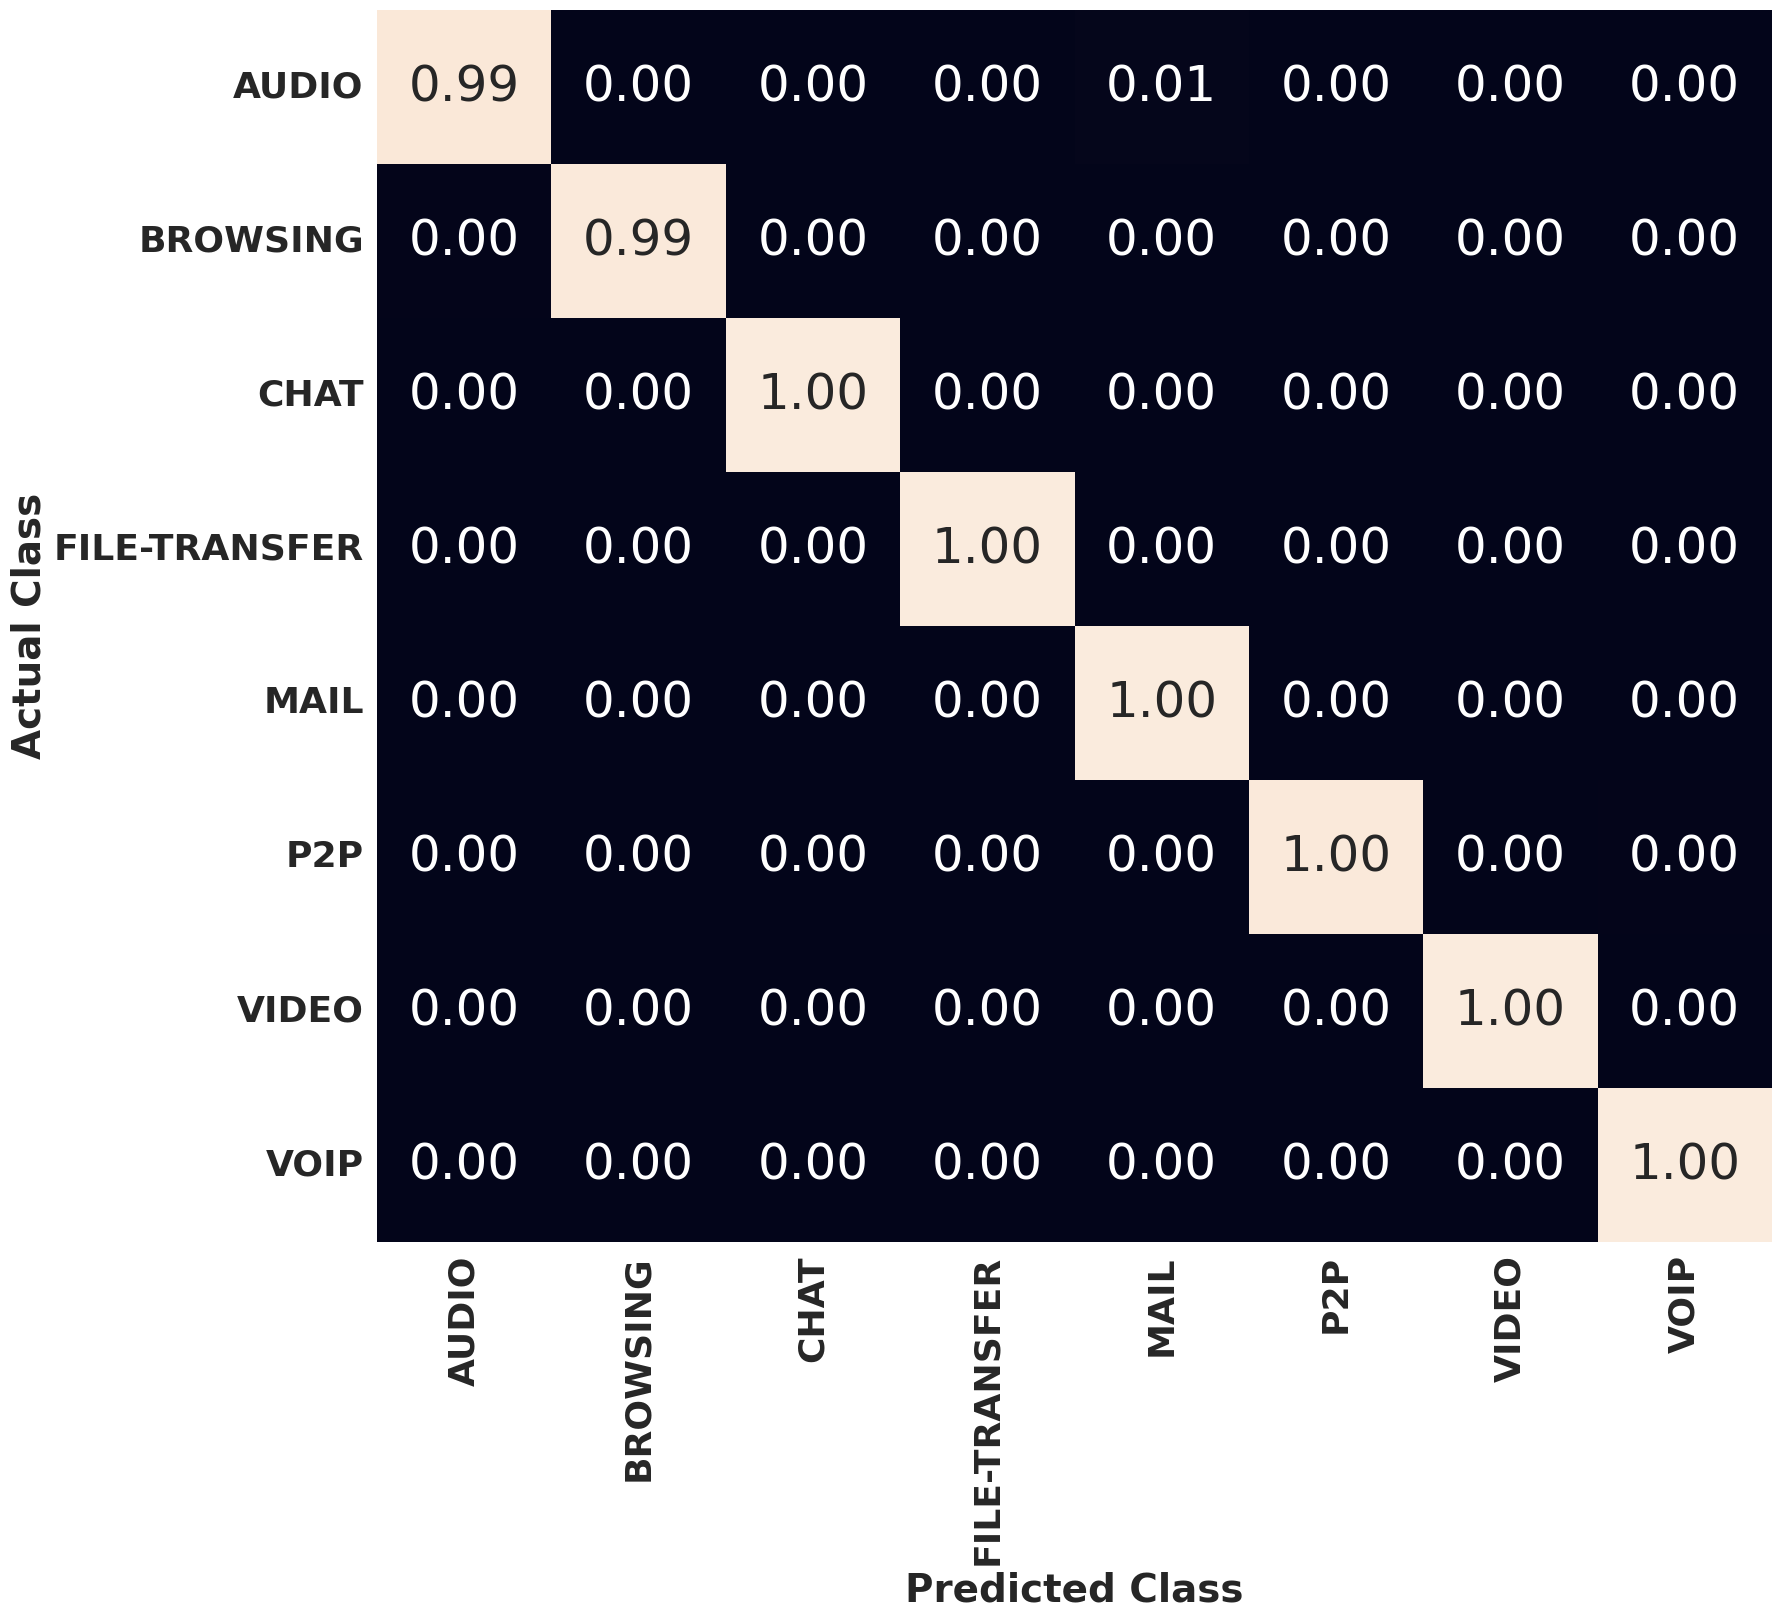

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred are your true labels and predicted labels, respectively
# Replace class_labels with the actual class labels in your problem
class_labels = ['AUDIO', 'BROWSING', 'CHAT', 'FILE-TRANSFER', 'MAIL', 'P2P',
       'VIDEO', 'VOIP']
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix to represent probabilities
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]

# Create a DataFrame from the normalized confusion matrix
cm_df = pd.DataFrame(cm_normalized, index=class_labels, columns=class_labels)
# Increase font size
sns.set(font_scale=3)
# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(18, 16))
heatmap = sns.heatmap(cm_df, annot=True, fmt='.2f', cbar=False)

# Customize x-axis and y-axis tick labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=26, fontweight='bold')
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=26, fontweight='bold')

# Customize labels and title
plt.xlabel('Predicted Class',fontsize=28, fontweight='bold')
plt.ylabel('Actual Class',fontsize=28, fontweight='bold')

# Save the plot as an EPS file
plt.savefig('/content/drive/MyDrive/xai/Tor Non Tor- Multi class/tor_confusion_matrix.eps', format='eps')

# Save the plot as a PNG file
plt.savefig('/content/drive/MyDrive/xai/Tor Non Tor- Multi class/tor_confusion_matrix.png', format='png')

# Show the plot
plt.show()


In [23]:
# Make predictions and measure prediction time per sample
import time
start_time = time.time()
y_pred = lgb.predict(X_test)
end_time = time.time()

# Calculate the prediction time per sample
total_samples = len(X_test)
prediction_time_per_sample = (end_time - start_time) / total_samples

print(f"Total prediction time: {end_time - start_time} seconds")
print(f"Prediction time per sample: {prediction_time_per_sample} seconds")

Total prediction time: 0.21118950843811035 seconds
Prediction time per sample: 0.00010501715983993553 seconds


### With 8 Features

In [24]:
# Assuming 'data' is your dataframe
columns_to_keep = [' Fwd IAT Std', ' Fwd IAT Min', ' Flow IAT Max', ' Fwd IAT Max', ' Flow Duration', ' Flow Bytes/s', ' Destination Port', ' Source Port','label']

# Filter 'data' dataframe to keep only the specified columns
data_8 = data[columns_to_keep]

In [25]:
#split the dataset into independent and dependent variables
X = data_8.iloc[:,:-1]
y = data_8.iloc[:,-1]

In [26]:
X.head()


,Fwd IAT Std,Fwd IAT Min,Flow IAT Max,Fwd IAT Max,Flow Duration,Flow Bytes/s,Destination Port,Source Port
0,4.371676e+05,29,3897923,3898126,7248168,2.112603e+04,110,57188
1,1.272066e+06,509,3743359,3743562,5157723,1.052790e+03,110,57188
2,0.000000e+00,41,41,41,41,1.324390e+07,110,57188
3,1.455802e+05,28,2007954,2007978,9543565,6.373855e+04,110,57188
4,3.400857e+04,31,608241,608450,9987537,1.996166e+05,110,57188


In [27]:
#splitting the dataset
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.25,random_state=10)

In [28]:
X_train.shape

(6033, 8)

In [29]:
from lightgbm import LGBMClassifier

In [30]:
lgb = LGBMClassifier(num_iterations=100,tree_learner='serial',random_state=10)
lgb.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1606
[LightGBM] [Info] Number of data points in the train set: 6033, number of used features: 8
[LightGBM] [Info] Start training from score -2.428356
[LightGBM] [Info] Start training from score -1.627502
[LightGBM] [Info] Start training from score -3.224361
[LightGBM] [Info] Start training from score -2.221892
[LightGBM] [Info] Start training from score -3.421796
[LightGBM] [Info] Start training from score -1.965663
[LightGBM] [Info] Start training from score -2.223423
[LightGBM] [Info] Start training from score -1.250859
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

LGBMClassifier(num_iterations=100, random_state=10, tree_learner='serial')

In [31]:
y_pred=lgb.predict(X_test)
y_pred

array([3, 7, 6, ..., 7, 3, 5])

In [32]:
predict_lgb = lambda x: lgb.predict_proba(x).astype(float)

In [33]:
#MAKING THE CONFUSION MATRIX

lgb_rpt = classification_report(y_test,y_pred)
print("classification report: \n", lgb_rpt)
print("Accuracy Score :" ,accuracy_score(y_test,y_pred))

classification report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       189
           1       1.00      0.98      0.99       419
           2       0.99      1.00      0.99        83
           3       0.97      1.00      0.99       210
           4       0.98      1.00      0.99        85
           5       1.00      1.00      1.00       240
           6       1.00      1.00      1.00       221
           7       1.00      0.99      1.00       564

    accuracy                           0.99      2011
   macro avg       0.99      1.00      0.99      2011
weighted avg       0.99      0.99      0.99      2011

Accuracy Score : 0.9935355544505221


In [34]:
# Replace 'y_true' and 'y_pred' with your actual and predicted labels
f1_weighted = f1_score(y_test,y_pred, average='weighted')
f1_weighted

0.9935421613973457

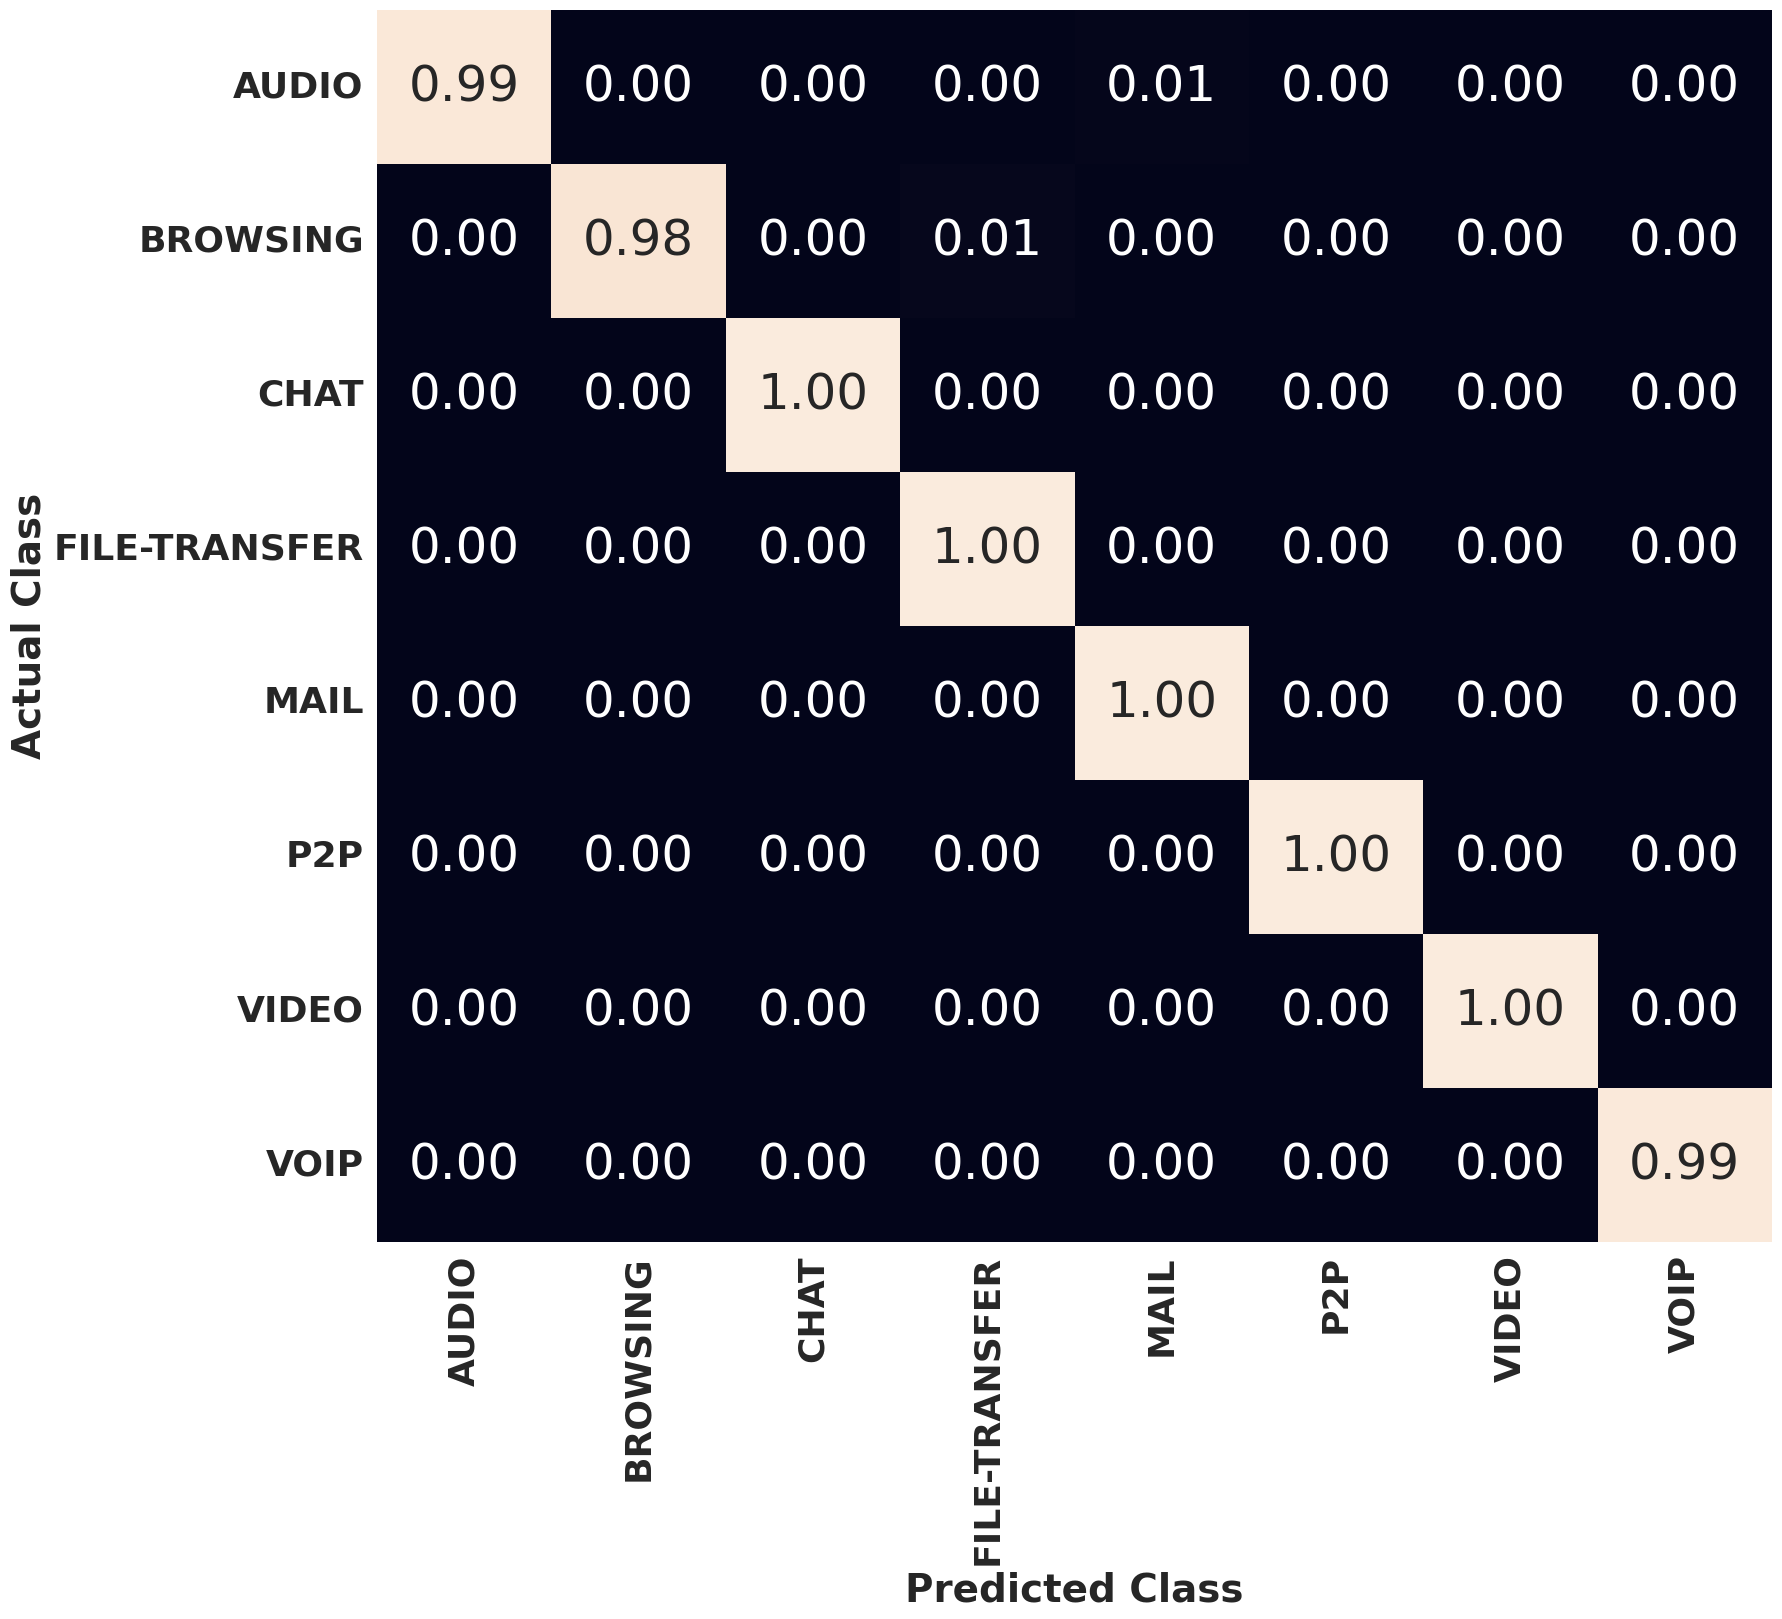

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred are your true labels and predicted labels, respectively
# Replace class_labels with the actual class labels in your problem
class_labels = ['AUDIO', 'BROWSING', 'CHAT', 'FILE-TRANSFER', 'MAIL', 'P2P',
       'VIDEO', 'VOIP']
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix to represent probabilities
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]

# Create a DataFrame from the normalized confusion matrix
cm_df = pd.DataFrame(cm_normalized, index=class_labels, columns=class_labels)
# Increase font size
sns.set(font_scale=3)
# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(18, 16))
heatmap = sns.heatmap(cm_df, annot=True, fmt='.2f', cbar=False)

# Customize x-axis and y-axis tick labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=26, fontweight='bold')
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=26, fontweight='bold')

# Customize labels and title
plt.xlabel('Predicted Class',fontsize=28, fontweight='bold')
plt.ylabel('Actual Class',fontsize=28, fontweight='bold')

# Save the plot as an EPS file
plt.savefig('/content/drive/MyDrive/xai/Tor Non Tor- Multi class/tor_confusion_matrix.eps', format='eps')

# Save the plot as a PNG file
plt.savefig('/content/drive/MyDrive/xai/Tor Non Tor- Multi class/tor_confusion_matrix.png', format='png')

# Show the plot
plt.show()


In [36]:
# Make predictions and measure prediction time per sample
import time
start_time = time.time()
y_pred = lgb.predict(X_test)
end_time = time.time()

# Calculate the prediction time per sample
total_samples = len(X_test)
prediction_time_per_sample = (end_time - start_time) / total_samples

print(f"Total prediction time: {end_time - start_time} seconds")
print(f"Prediction time per sample: {prediction_time_per_sample} seconds")

Total prediction time: 0.17749452590942383 seconds
Prediction time per sample: 8.826182292860459e-05 seconds


### With 12 Features

In [37]:
# Assuming 'data' is your dataframe
columns_to_keep = [' Flow IAT Std', ' Flow IAT Min', ' Bwd IAT Min', 'Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Min', ' Flow IAT Max', ' Fwd IAT Max', ' Flow Duration', ' Flow Bytes/s', ' Destination Port', ' Source Port','label']

# Filter 'data' dataframe to keep only the specified columns
data_12 = data[columns_to_keep]

In [38]:
#split the dataset into independent and dependent variables
X = data_12.iloc[:,:-1]
y = data_12.iloc[:,-1]

In [39]:
X.head()


,Flow IAT Std,Flow IAT Min,Bwd IAT Min,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Min,Flow IAT Max,Fwd IAT Max,Flow Duration,Flow Bytes/s,Destination Port,Source Port
0,273869.262513,5,7,89483.555556,4.371676e+05,29,3897923,3898126,7248168,2.112603e+04,110,57188
1,878838.525555,135,451,644715.375000,1.272066e+06,509,3743359,3743562,5157723,1.052790e+03,110,57188
2,0.000000,41,0,41.000000,0.000000e+00,41,41,41,41,1.324390e+07,110,57188
3,90072.192523,5,5,31705.295681,1.455802e+05,28,2007954,2007978,9543565,6.373855e+04,110,57188
4,20365.733229,5,5,11743.344706,3.400857e+04,31,608241,608450,9987537,1.996166e+05,110,57188


In [40]:
#splitting the dataset
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.25,random_state=10)

In [41]:
X_train.shape

(6033, 12)

In [42]:
from lightgbm import LGBMClassifier

In [43]:
lgb = LGBMClassifier(num_iterations=100,tree_learner='serial',random_state=10)
lgb.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2611
[LightGBM] [Info] Number of data points in the train set: 6033, number of used features: 12
[LightGBM] [Info] Start training from score -2.428356
[LightGBM] [Info] Start training from score -1.627502
[LightGBM] [Info] Start training from score -3.224361
[LightGBM] [Info] Start training from score -2.221892
[LightGBM] [Info] Start training from score -3.421796
[LightGBM] [Info] Start training from score -1.965663
[LightGBM] [Info] Start training from score -2.223423
[LightGBM] [Info] Start training from score -1.250859
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMClassifier(num_iterations=100, random_state=10, tree_learner='serial')

In [44]:
y_pred=lgb.predict(X_test)
y_pred

array([3, 7, 6, ..., 7, 3, 5])

In [45]:
predict_lgb = lambda x: lgb.predict_proba(x).astype(float)

In [46]:
#MAKING THE CONFUSION MATRIX

lgb_rpt = classification_report(y_test,y_pred)
print("classification report: \n", lgb_rpt)
print("Accuracy Score :" ,accuracy_score(y_test,y_pred))

classification report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       189
           1       1.00      0.99      0.99       419
           2       1.00      1.00      1.00        83
           3       0.99      1.00      0.99       210
           4       0.98      1.00      0.99        85
           5       1.00      1.00      1.00       240
           6       1.00      1.00      1.00       221
           7       0.99      1.00      1.00       564

    accuracy                           0.99      2011
   macro avg       0.99      1.00      0.99      2011
weighted avg       0.99      0.99      0.99      2011

Accuracy Score : 0.9945300845350572


In [47]:
# Replace 'y_true' and 'y_pred' with your actual and predicted labels
f1_weighted = f1_score(y_test,y_pred, average='weighted')
f1_weighted

0.9945319674339587

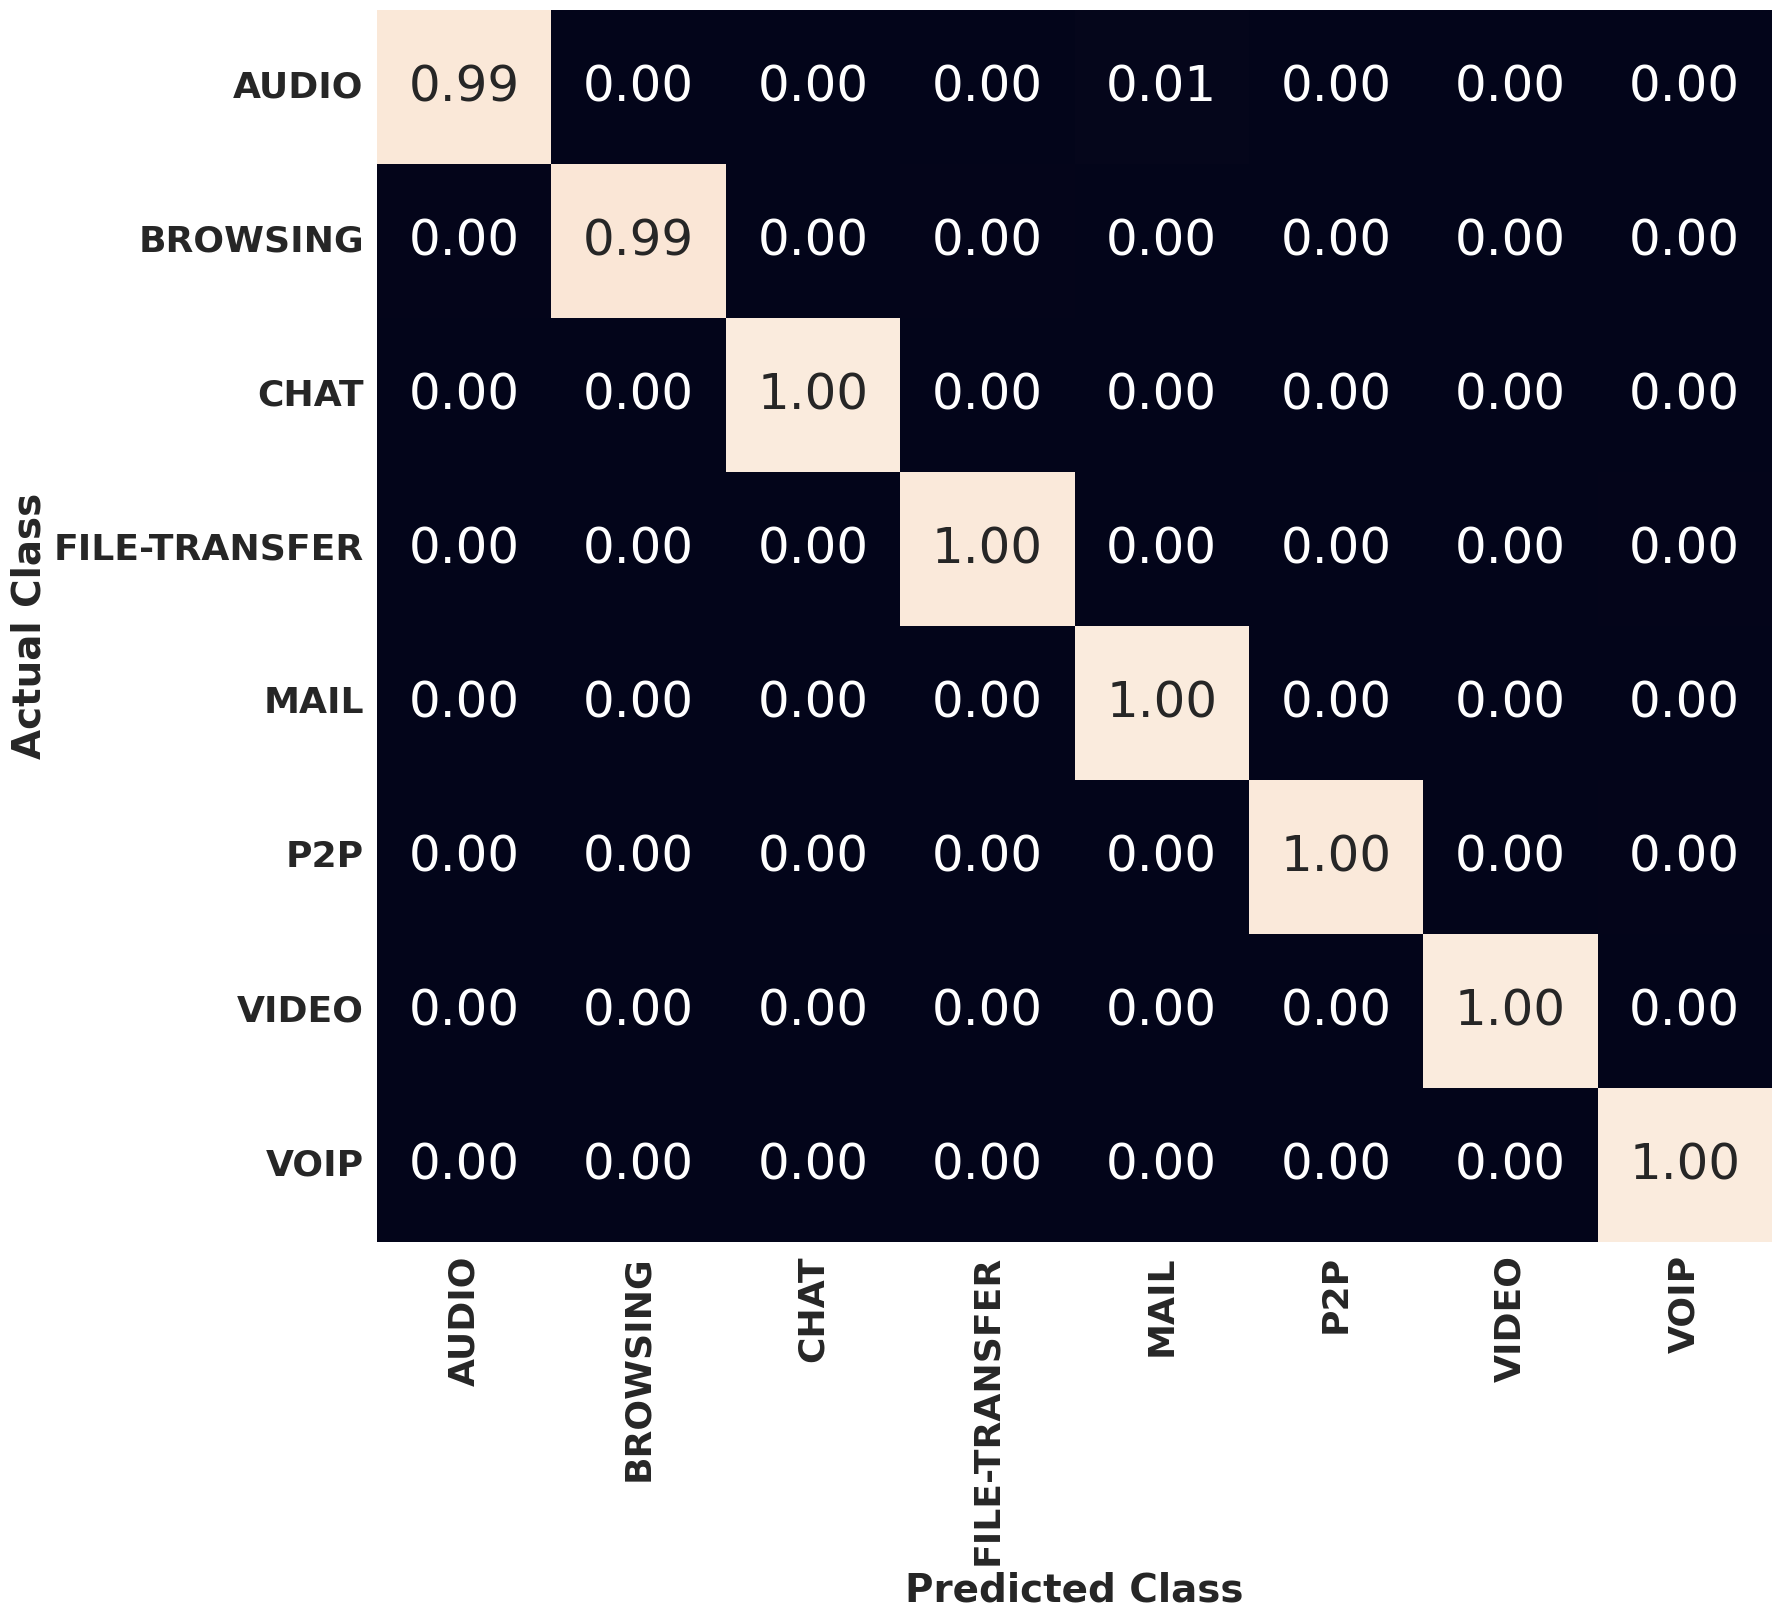

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred are your true labels and predicted labels, respectively
# Replace class_labels with the actual class labels in your problem
class_labels = ['AUDIO', 'BROWSING', 'CHAT', 'FILE-TRANSFER', 'MAIL', 'P2P',
       'VIDEO', 'VOIP']
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix to represent probabilities
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]

# Create a DataFrame from the normalized confusion matrix
cm_df = pd.DataFrame(cm_normalized, index=class_labels, columns=class_labels)
# Increase font size
sns.set(font_scale=3)
# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(18, 16))
heatmap = sns.heatmap(cm_df, annot=True, fmt='.2f', cbar=False)

# Customize x-axis and y-axis tick labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=26, fontweight='bold')
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=26, fontweight='bold')

# Customize labels and title
plt.xlabel('Predicted Class',fontsize=28, fontweight='bold')
plt.ylabel('Actual Class',fontsize=28, fontweight='bold')

# Save the plot as an EPS file
plt.savefig('/content/drive/MyDrive/xai/Tor Non Tor- Multi class/tor_confusion_matrix.eps', format='eps')

# Save the plot as a PNG file
plt.savefig('/content/drive/MyDrive/xai/Tor Non Tor- Multi class/tor_confusion_matrix.png', format='png')

# Show the plot
plt.show()


In [49]:
# Make predictions and measure prediction time per sample
import time
start_time = time.time()
y_pred = lgb.predict(X_test)
end_time = time.time()

# Calculate the prediction time per sample
total_samples = len(X_test)
prediction_time_per_sample = (end_time - start_time) / total_samples

print(f"Total prediction time: {end_time - start_time} seconds")
print(f"Prediction time per sample: {prediction_time_per_sample} seconds")

Total prediction time: 0.15471863746643066 seconds
Prediction time per sample: 7.693616979931908e-05 seconds


### With 16 Features

In [50]:
# Assuming 'data' is your dataframe
columns_to_keep = [' Flow Packets/s', ' Bwd IAT Max', ' Bwd IAT Std', 'Bwd IAT Mean', ' Flow IAT Std', ' Flow IAT Min', ' Bwd IAT Min', 'Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Min', ' Flow IAT Max', ' Fwd IAT Max', ' Flow Duration', ' Flow Bytes/s', ' Destination Port', ' Source Port','label']

# Filter 'data' dataframe to keep only the specified columns
data_16 = data[columns_to_keep]

In [51]:
#split the dataset into independent and dependent variables
X = data_16.iloc[:,:-1]
y = data_16.iloc[:,-1]

In [52]:
X.head()


,Flow Packets/s,Bwd IAT Max,Bwd IAT Std,Bwd IAT Mean,Flow IAT Std,Flow IAT Min,Bwd IAT Min,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Min,Flow IAT Max,Fwd IAT Max,Flow Duration,Flow Bytes/s,Destination Port,Source Port
0,29.110804,3898131,3.498551e+05,56614.039062,273869.262513,5,7,89483.555556,4.371676e+05,29,3897923,3898126,7248168,2.112603e+04,110,57188
1,3.683796,3743573,1.209110e+06,568901.666667,878838.525555,135,451,644715.375000,1.272066e+06,509,3743359,3743562,5157723,1.052790e+03,110,57188
2,48780.487805,0,0.000000e+00,0.000000,0.000000,41,0,41.000000,0.000000e+00,41,41,41,41,1.324390e+07,110,57188
3,83.930900,2008877,1.141093e+05,19163.236948,90072.192523,5,5,31705.295681,1.455802e+05,28,2007954,2007978,9543565,6.373855e+04,110,57188
4,245.806348,608241,2.533212e+04,6230.089208,20365.733229,5,5,11743.344706,3.400857e+04,31,608241,608450,9987537,1.996166e+05,110,57188


In [53]:
#splitting the dataset
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.25,random_state=10)

In [54]:
X_train.shape

(6033, 16)

In [55]:
from lightgbm import LGBMClassifier

In [56]:
lgb = LGBMClassifier(num_iterations=100,tree_learner='serial',random_state=10)
lgb.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3631
[LightGBM] [Info] Number of data points in the train set: 6033, number of used features: 16
[LightGBM] [Info] Start training from score -2.428356
[LightGBM] [Info] Start training from score -1.627502
[LightGBM] [Info] Start training from score -3.224361
[LightGBM] [Info] Start training from score -2.221892
[LightGBM] [Info] Start training from score -3.421796
[LightGBM] [Info] Start training from score -1.965663
[LightGBM] [Info] Start training from score -2.223423
[LightGBM] [Info] Start training from score -1.250859
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

LGBMClassifier(num_iterations=100, random_state=10, tree_learner='serial')

In [57]:
y_pred=lgb.predict(X_test)
y_pred

array([3, 7, 6, ..., 7, 3, 5])

In [58]:
predict_lgb = lambda x: lgb.predict_proba(x).astype(float)

In [59]:
#MAKING THE CONFUSION MATRIX

lgb_rpt = classification_report(y_test,y_pred)
print("classification report: \n", lgb_rpt)
print("Accuracy Score :" ,accuracy_score(y_test,y_pred))

classification report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       189
           1       0.99      0.99      0.99       419
           2       1.00      1.00      1.00        83
           3       0.99      1.00      0.99       210
           4       0.98      1.00      0.99        85
           5       1.00      1.00      1.00       240
           6       1.00      1.00      1.00       221
           7       1.00      0.99      1.00       564

    accuracy                           0.99      2011
   macro avg       0.99      1.00      0.99      2011
weighted avg       0.99      0.99      0.99      2011

Accuracy Score : 0.9945300845350572


In [60]:
# Replace 'y_true' and 'y_pred' with your actual and predicted labels
f1_weighted = f1_score(y_test,y_pred, average='weighted')
f1_weighted

0.994534037768549

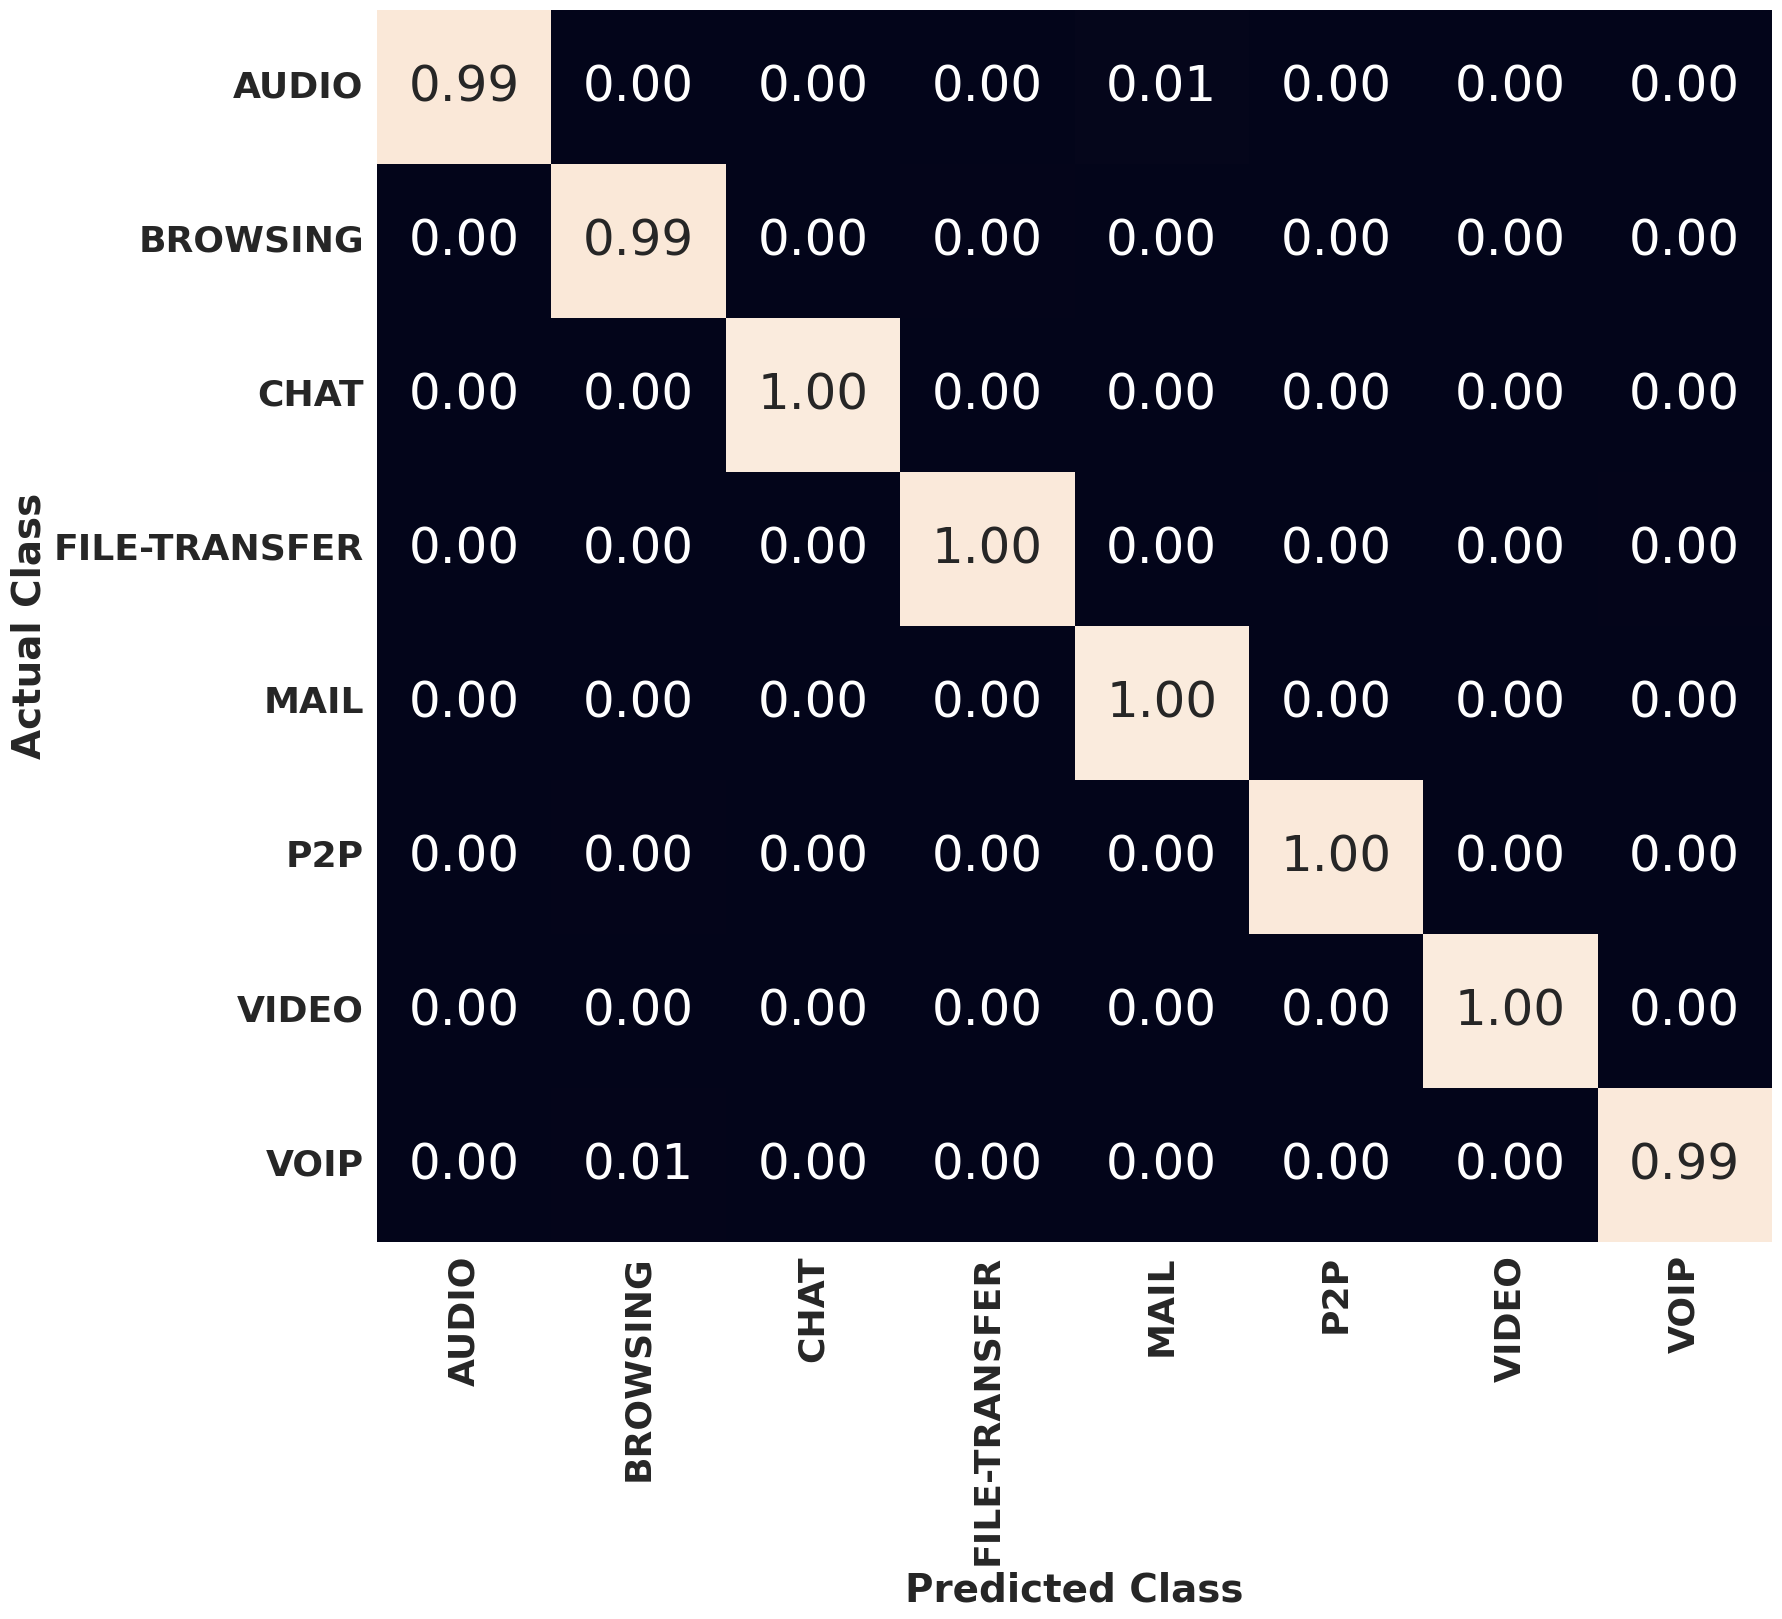

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred are your true labels and predicted labels, respectively
# Replace class_labels with the actual class labels in your problem
class_labels = ['AUDIO', 'BROWSING', 'CHAT', 'FILE-TRANSFER', 'MAIL', 'P2P',
       'VIDEO', 'VOIP']
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix to represent probabilities
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]

# Create a DataFrame from the normalized confusion matrix
cm_df = pd.DataFrame(cm_normalized, index=class_labels, columns=class_labels)
# Increase font size
sns.set(font_scale=3)
# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(18, 16))
heatmap = sns.heatmap(cm_df, annot=True, fmt='.2f', cbar=False)

# Customize x-axis and y-axis tick labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=26, fontweight='bold')
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=26, fontweight='bold')

# Customize labels and title
plt.xlabel('Predicted Class',fontsize=28, fontweight='bold')
plt.ylabel('Actual Class',fontsize=28, fontweight='bold')

# Save the plot as an EPS file
plt.savefig('/content/drive/MyDrive/xai/Tor Non Tor- Multi class/tor_confusion_matrix.eps', format='eps')

# Save the plot as a PNG file
plt.savefig('/content/drive/MyDrive/xai/Tor Non Tor- Multi class/tor_confusion_matrix.png', format='png')

# Show the plot
plt.show()


In [62]:
# Make predictions and measure prediction time per sample
import time
start_time = time.time()
y_pred = lgb.predict(X_test)
end_time = time.time()

# Calculate the prediction time per sample
total_samples = len(X_test)
prediction_time_per_sample = (end_time - start_time) / total_samples

print(f"Total prediction time: {end_time - start_time} seconds")
print(f"Prediction time per sample: {prediction_time_per_sample} seconds")

Total prediction time: 0.18145012855529785 seconds
Prediction time per sample: 9.022880584549868e-05 seconds


### With 20 Features

In [63]:
# Assuming 'data' is your dataframe
columns_to_keep = [' Idle Std', 'Idle Mean', 'Active Mean', ' Flow IAT Mean', ' Flow Packets/s', ' Bwd IAT Max', ' Bwd IAT Std', 'Bwd IAT Mean', ' Flow IAT Std', ' Flow IAT Min', ' Bwd IAT Min', 'Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Min', ' Flow IAT Max', ' Fwd IAT Max', ' Flow Duration', ' Flow Bytes/s', ' Destination Port', ' Source Port','label']

# Filter 'data' dataframe to keep only the specified columns
data_20 = data[columns_to_keep]

In [64]:
#split the dataset into independent and dependent variables
X = data_20.iloc[:,:-1]
y = data_20.iloc[:,-1]

In [65]:
X.head()


,Idle Std,Idle Mean,Active Mean,Flow IAT Mean,Flow Packets/s,Bwd IAT Max,Bwd IAT Std,Bwd IAT Mean,Flow IAT Std,Flow IAT Min,Bwd IAT Min,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Min,Flow IAT Max,Fwd IAT Max,Flow Duration,Flow Bytes/s,Destination Port,Source Port
0,0,0,0,34515.085714,29.110804,3898131,3.498551e+05,56614.039062,273869.262513,5,7,89483.555556,4.371676e+05,29,3897923,3898126,7248168,2.112603e+04,110,57188
1,0,0,0,286540.166667,3.683796,3743573,1.209110e+06,568901.666667,878838.525555,135,451,644715.375000,1.272066e+06,509,3743359,3743562,5157723,1.052790e+03,110,57188
2,0,0,0,41.000000,48780.487805,0,0.000000e+00,0.000000,0.000000,41,0,41.000000,0.000000e+00,41,41,41,41,1.324390e+07,110,57188
3,0,0,0,11929.456250,83.930900,2008877,1.141093e+05,19163.236948,90072.192523,5,5,31705.295681,1.455802e+05,28,2007954,2007978,9543565,6.373855e+04,110,57188
4,0,0,0,4069.900978,245.806348,608241,2.533212e+04,6230.089208,20365.733229,5,5,11743.344706,3.400857e+04,31,608241,608450,9987537,1.996166e+05,110,57188


In [66]:
#splitting the dataset
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.25,random_state=10)

In [67]:
X_train.shape

(6033, 20)

In [68]:
from lightgbm import LGBMClassifier

In [69]:
lgb = LGBMClassifier(num_iterations=100,tree_learner='serial',random_state=10)
lgb.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4160
[LightGBM] [Info] Number of data points in the train set: 6033, number of used features: 19
[LightGBM] [Info] Start training from score -2.428356
[LightGBM] [Info] Start training from score -1.627502
[LightGBM] [Info] Start training from score -3.224361
[LightGBM] [Info] Start training from score -2.221892
[LightGBM] [Info] Start training from score -3.421796
[LightGBM] [Info] Start training from score -1.965663
[LightGBM] [Info] Start training from score -2.223423
[LightGBM] [Info] Start training from score -1.250859
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

LGBMClassifier(num_iterations=100, random_state=10, tree_learner='serial')

In [70]:
y_pred=lgb.predict(X_test)
y_pred

array([3, 7, 6, ..., 7, 3, 5])

In [71]:
predict_lgb = lambda x: lgb.predict_proba(x).astype(float)

In [72]:
#MAKING THE CONFUSION MATRIX

lgb_rpt = classification_report(y_test,y_pred)
print("classification report: \n", lgb_rpt)
print("Accuracy Score :" ,accuracy_score(y_test,y_pred))

classification report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       189
           1       0.99      0.99      0.99       419
           2       1.00      1.00      1.00        83
           3       0.99      1.00      0.99       210
           4       0.98      1.00      0.99        85
           5       1.00      1.00      1.00       240
           6       1.00      1.00      1.00       221
           7       1.00      0.99      1.00       564

    accuracy                           0.99      2011
   macro avg       0.99      1.00      0.99      2011
weighted avg       0.99      0.99      0.99      2011

Accuracy Score : 0.9945300845350572


In [73]:
# Replace 'y_true' and 'y_pred' with your actual and predicted labels
f1_weighted = f1_score(y_test,y_pred, average='weighted')
f1_weighted

0.994534037768549

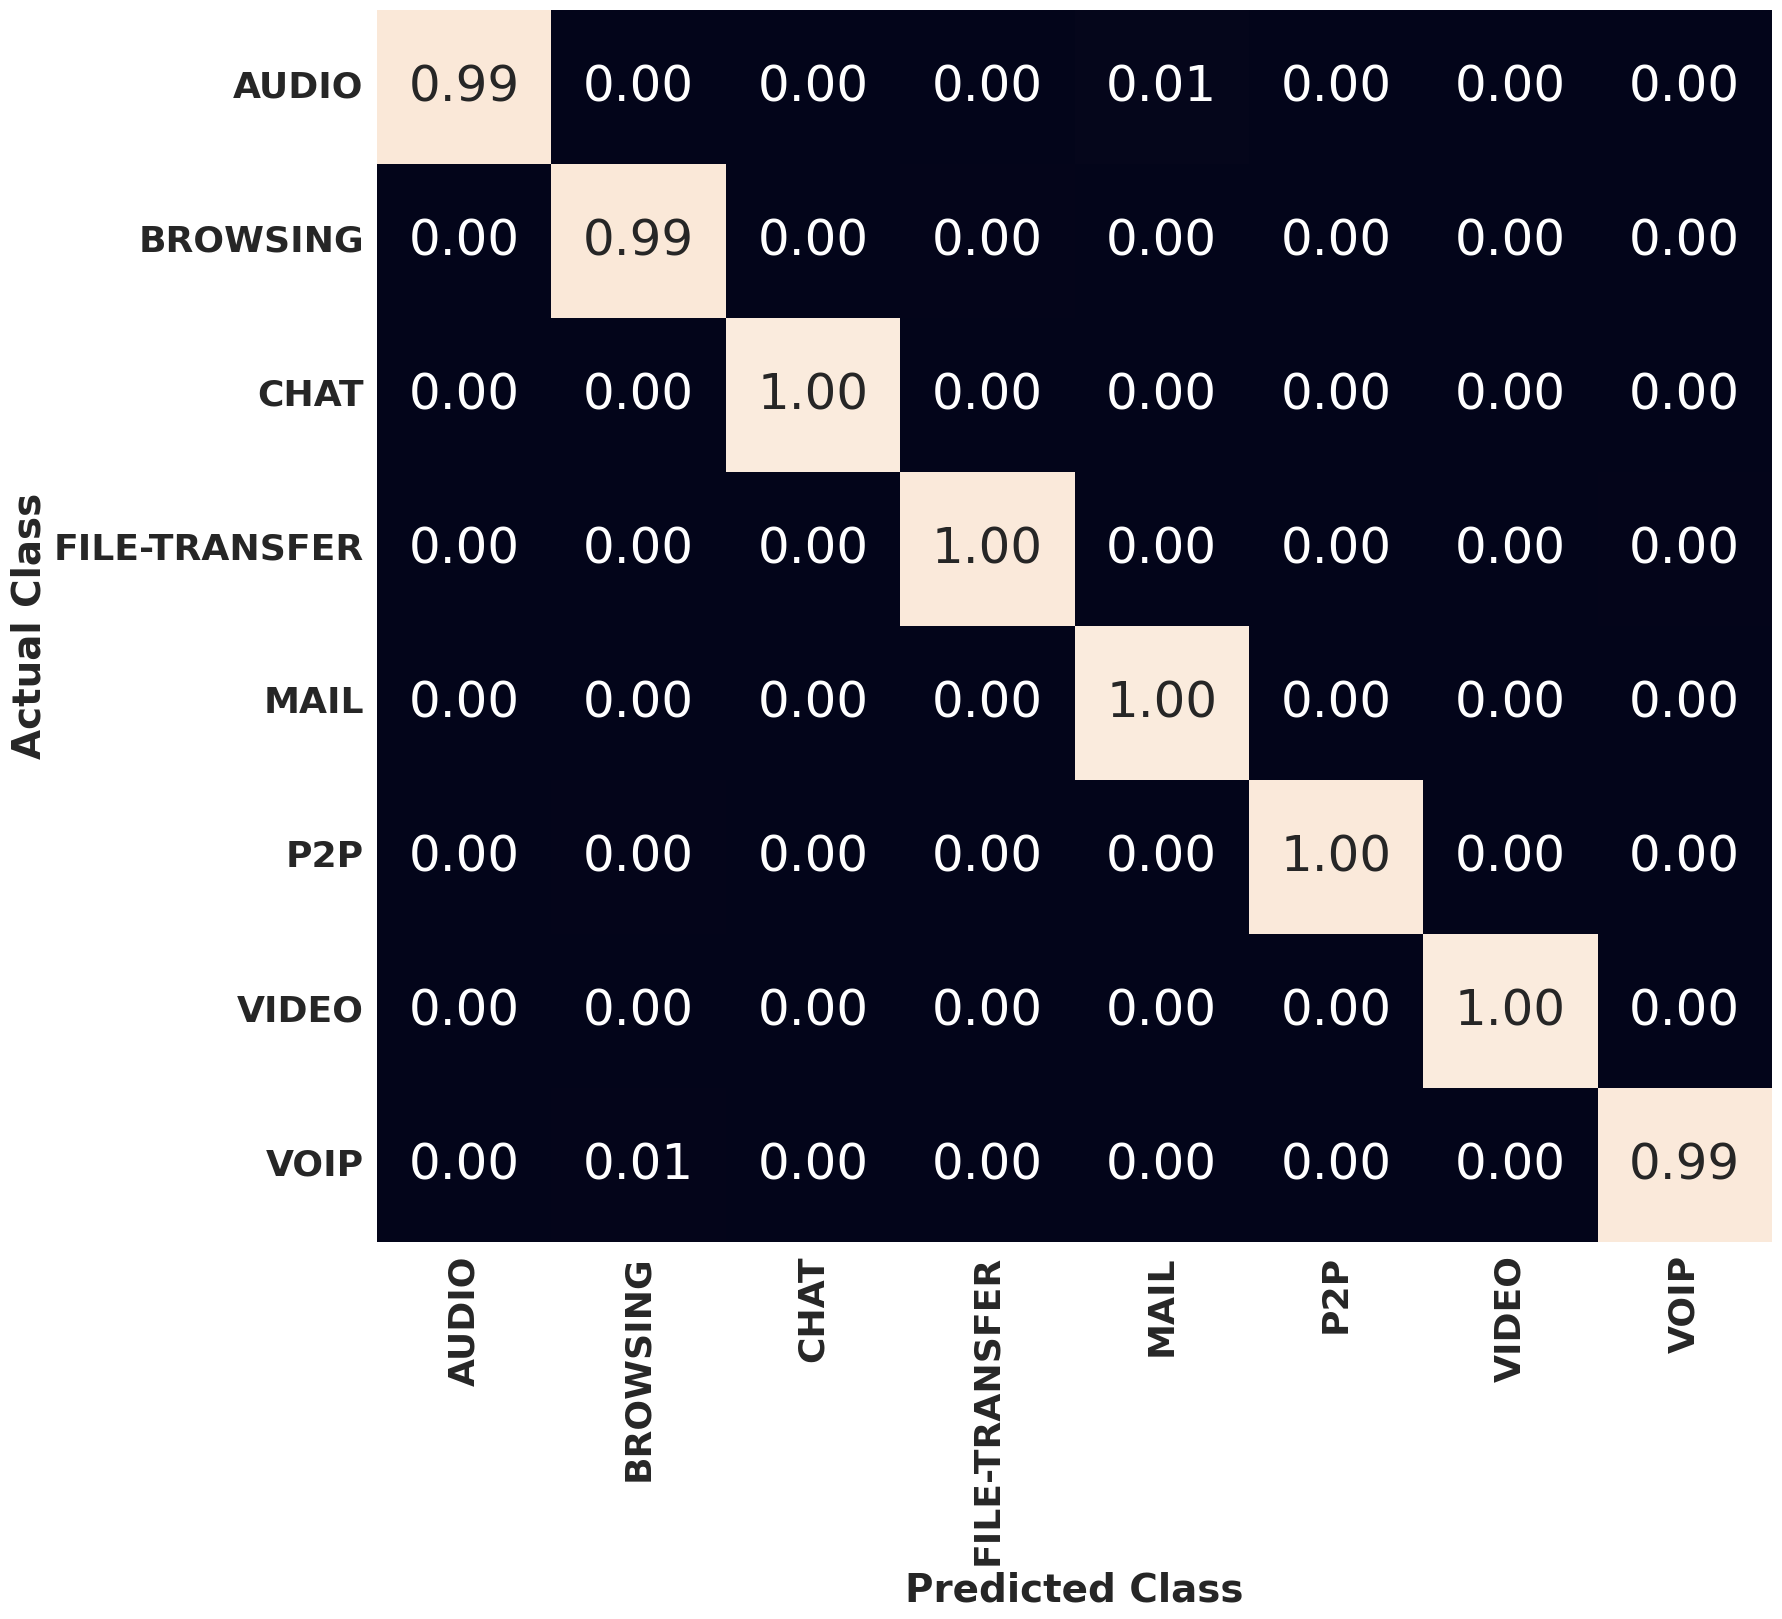

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred are your true labels and predicted labels, respectively
# Replace class_labels with the actual class labels in your problem
class_labels = ['AUDIO', 'BROWSING', 'CHAT', 'FILE-TRANSFER', 'MAIL', 'P2P',
       'VIDEO', 'VOIP']
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix to represent probabilities
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]

# Create a DataFrame from the normalized confusion matrix
cm_df = pd.DataFrame(cm_normalized, index=class_labels, columns=class_labels)
# Increase font size
sns.set(font_scale=3)
# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(18, 16))
heatmap = sns.heatmap(cm_df, annot=True, fmt='.2f', cbar=False)

# Customize x-axis and y-axis tick labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=26, fontweight='bold')
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=26, fontweight='bold')

# Customize labels and title
plt.xlabel('Predicted Class',fontsize=28, fontweight='bold')
plt.ylabel('Actual Class',fontsize=28, fontweight='bold')

# Save the plot as an EPS file
plt.savefig('/content/drive/MyDrive/xai/Tor Non Tor- Multi class/tor_confusion_matrix.eps', format='eps')

# Save the plot as a PNG file
plt.savefig('/content/drive/MyDrive/xai/Tor Non Tor- Multi class/tor_confusion_matrix.png', format='png')

# Show the plot
plt.show()


In [75]:
# Make predictions and measure prediction time per sample
import time
start_time = time.time()
y_pred = lgb.predict(X_test)
end_time = time.time()

# Calculate the prediction time per sample
total_samples = len(X_test)
prediction_time_per_sample = (end_time - start_time) / total_samples

print(f"Total prediction time: {end_time - start_time} seconds")
print(f"Prediction time per sample: {prediction_time_per_sample} seconds")

Total prediction time: 0.18344426155090332 seconds
Prediction time per sample: 9.122041847384551e-05 seconds


### With 24 Features

In [76]:
# Assuming 'data' is your dataframe
columns_to_keep = [' Active Std', ' Active Min', ' Active Max', ' Protocol', ' Idle Std', 'Idle Mean', 'Active Mean', ' Flow IAT Mean', ' Flow Packets/s', ' Bwd IAT Max', ' Bwd IAT Std', 'Bwd IAT Mean', ' Flow IAT Std', ' Flow IAT Min', ' Bwd IAT Min', 'Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Min', ' Flow IAT Max', ' Fwd IAT Max', ' Flow Duration', ' Flow Bytes/s', ' Destination Port', ' Source Port','label']

# Filter 'data' dataframe to keep only the specified columns
data_24 = data[columns_to_keep]

In [77]:
#split the dataset into independent and dependent variables
X = data_24.iloc[:,:-1]
y = data_24.iloc[:,-1]

In [78]:
X.head()


,Active Std,Active Min,Active Max,Protocol,Idle Std,Idle Mean,Active Mean,Flow IAT Mean,Flow Packets/s,Bwd IAT Max,...,Bwd IAT Min,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Min,Flow IAT Max,Fwd IAT Max,Flow Duration,Flow Bytes/s,Destination Port,Source Port
0,0,0,0,6,0,0,0,34515.085714,29.110804,3898131,...,7,89483.555556,4.371676e+05,29,3897923,3898126,7248168,2.112603e+04,110,57188
1,0,0,0,6,0,0,0,286540.166667,3.683796,3743573,...,451,644715.375000,1.272066e+06,509,3743359,3743562,5157723,1.052790e+03,110,57188
2,0,0,0,6,0,0,0,41.000000,48780.487805,0,...,0,41.000000,0.000000e+00,41,41,41,41,1.324390e+07,110,57188
3,0,0,0,6,0,0,0,11929.456250,83.930900,2008877,...,5,31705.295681,1.455802e+05,28,2007954,2007978,9543565,6.373855e+04,110,57188
4,0,0,0,6,0,0,0,4069.900978,245.806348,608241,...,5,11743.344706,3.400857e+04,31,608241,608450,9987537,1.996166e+05,110,57188


In [79]:
#splitting the dataset
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.25,random_state=10)

In [80]:
X_train.shape

(6033, 24)

In [81]:
from lightgbm import LGBMClassifier

In [82]:
lgb = LGBMClassifier(num_iterations=100,tree_learner='serial',random_state=10)
lgb.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4434
[LightGBM] [Info] Number of data points in the train set: 6033, number of used features: 21
[LightGBM] [Info] Start training from score -2.428356
[LightGBM] [Info] Start training from score -1.627502
[LightGBM] [Info] Start training from score -3.224361
[LightGBM] [Info] Start training from score -2.221892
[LightGBM] [Info] Start training from score -3.421796
[LightGBM] [Info] Start training from score -1.965663
[LightGBM] [Info] Start training from score -2.223423
[LightGBM] [Info] Start training from score -1.250859
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMClassifier(num_iterations=100, random_state=10, tree_learner='serial')

In [83]:
y_pred=lgb.predict(X_test)
y_pred

array([3, 7, 6, ..., 7, 3, 5])

In [84]:
predict_lgb = lambda x: lgb.predict_proba(x).astype(float)

In [85]:
#MAKING THE CONFUSION MATRIX

lgb_rpt = classification_report(y_test,y_pred)
print("classification report: \n", lgb_rpt)
print("Accuracy Score :" ,accuracy_score(y_test,y_pred))

classification report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       189
           1       0.99      0.99      0.99       419
           2       1.00      1.00      1.00        83
           3       0.99      1.00      0.99       210
           4       0.98      1.00      0.99        85
           5       1.00      1.00      1.00       240
           6       1.00      1.00      1.00       221
           7       1.00      0.99      1.00       564

    accuracy                           0.99      2011
   macro avg       0.99      1.00      0.99      2011
weighted avg       0.99      0.99      0.99      2011

Accuracy Score : 0.9945300845350572


In [86]:
# Replace 'y_true' and 'y_pred' with your actual and predicted labels
f1_weighted = f1_score(y_test,y_pred, average='weighted')
f1_weighted

0.994534037768549

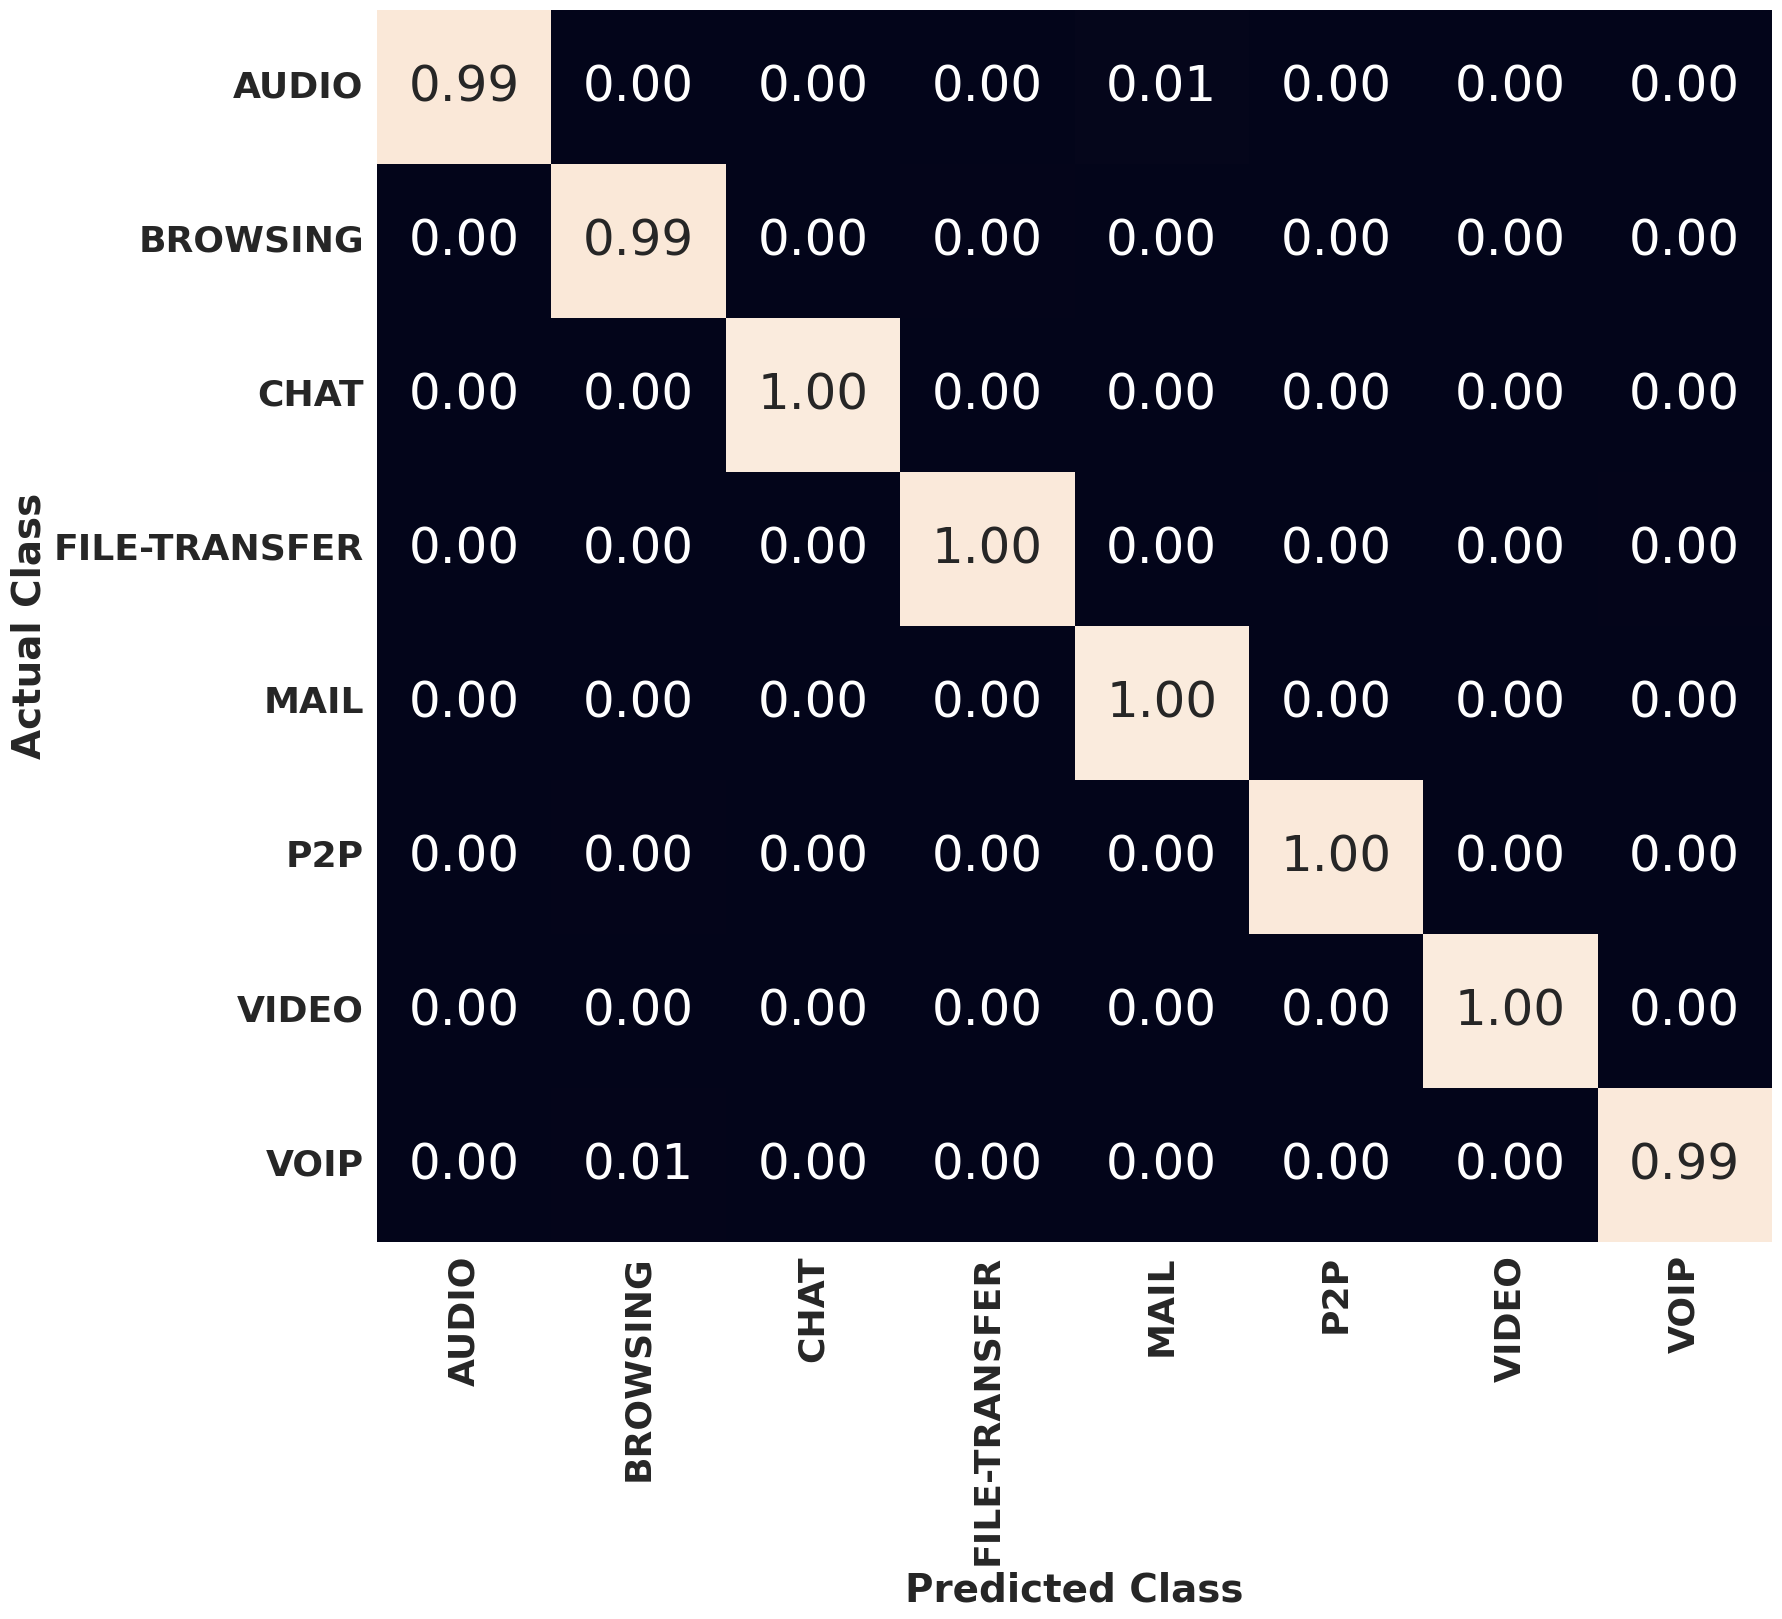

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred are your true labels and predicted labels, respectively
# Replace class_labels with the actual class labels in your problem
class_labels = ['AUDIO', 'BROWSING', 'CHAT', 'FILE-TRANSFER', 'MAIL', 'P2P',
       'VIDEO', 'VOIP']
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix to represent probabilities
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]

# Create a DataFrame from the normalized confusion matrix
cm_df = pd.DataFrame(cm_normalized, index=class_labels, columns=class_labels)
# Increase font size
sns.set(font_scale=3)
# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(18, 16))
heatmap = sns.heatmap(cm_df, annot=True, fmt='.2f', cbar=False)

# Customize x-axis and y-axis tick labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=26, fontweight='bold')
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=26, fontweight='bold')

# Customize labels and title
plt.xlabel('Predicted Class',fontsize=28, fontweight='bold')
plt.ylabel('Actual Class',fontsize=28, fontweight='bold')

# Save the plot as an EPS file
plt.savefig('/content/drive/MyDrive/xai/Tor Non Tor- Multi class/tor_confusion_matrix.eps', format='eps')

# Save the plot as a PNG file
plt.savefig('/content/drive/MyDrive/xai/Tor Non Tor- Multi class/tor_confusion_matrix.png', format='png')

# Show the plot
plt.show()


In [88]:
# Make predictions and measure prediction time per sample
import time
start_time = time.time()
y_pred = lgb.predict(X_test)
end_time = time.time()

# Calculate the prediction time per sample
total_samples = len(X_test)
prediction_time_per_sample = (end_time - start_time) / total_samples

print(f"Total prediction time: {end_time - start_time} seconds")
print(f"Prediction time per sample: {prediction_time_per_sample} seconds")

Total prediction time: 0.16516542434692383 seconds
Prediction time per sample: 8.213099171900737e-05 seconds


### With 28 Features

In [89]:
#split the dataset into independent and dependent variables
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [90]:
X.head()


,Source Port,Destination Port,Protocol,Flow Duration,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,...,Bwd IAT Max,Bwd IAT Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,57188,110,6,7248168,2.112603e+04,29.110804,34515.085714,273869.262513,3897923,5,...,3898131,7,0,0,0,0,0,0,0,0
1,57188,110,6,5157723,1.052790e+03,3.683796,286540.166667,878838.525555,3743359,135,...,3743573,451,0,0,0,0,0,0,0,0
2,57188,110,6,41,1.324390e+07,48780.487805,41.000000,0.000000,41,41,...,0,0,0,0,0,0,0,0,0,0
3,57188,110,6,9543565,6.373855e+04,83.930900,11929.456250,90072.192523,2007954,5,...,2008877,5,0,0,0,0,0,0,0,0
4,57188,110,6,9987537,1.996166e+05,245.806348,4069.900978,20365.733229,608241,5,...,608241,5,0,0,0,0,0,0,0,0


In [91]:
#splitting the dataset
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.25,random_state=10)

In [92]:
X_train.shape

(6033, 26)

In [93]:
from lightgbm import LGBMClassifier

In [94]:
lgb = LGBMClassifier(num_iterations=100,tree_learner='serial',random_state=10)
lgb.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4708
[LightGBM] [Info] Number of data points in the train set: 6033, number of used features: 23
[LightGBM] [Info] Start training from score -2.428356
[LightGBM] [Info] Start training from score -1.627502
[LightGBM] [Info] Start training from score -3.224361
[LightGBM] [Info] Start training from score -2.221892
[LightGBM] [Info] Start training from score -3.421796
[LightGBM] [Info] Start training from score -1.965663
[LightGBM] [Info] Start training from score -2.223423
[LightGBM] [Info] Start training from score -1.250859
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMClassifier(num_iterations=100, random_state=10, tree_learner='serial')

In [95]:
y_pred=lgb.predict(X_test)
y_pred

array([3, 7, 6, ..., 7, 3, 5])

In [96]:
predict_lgb = lambda x: lgb.predict_proba(x).astype(float)

In [97]:
#MAKING THE CONFUSION MATRIX

lgb_rpt = classification_report(y_test,y_pred)
print("classification report: \n", lgb_rpt)
print("Accuracy Score :" ,accuracy_score(y_test,y_pred))

classification report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       189
           1       0.99      0.99      0.99       419
           2       1.00      1.00      1.00        83
           3       0.99      1.00      0.99       210
           4       0.98      1.00      0.99        85
           5       1.00      1.00      1.00       240
           6       1.00      1.00      1.00       221
           7       1.00      0.99      1.00       564

    accuracy                           0.99      2011
   macro avg       0.99      1.00      0.99      2011
weighted avg       0.99      0.99      0.99      2011

Accuracy Score : 0.9945300845350572


In [98]:
# Replace 'y_true' and 'y_pred' with your actual and predicted labels
f1_weighted = f1_score(y_test,y_pred, average='weighted')
f1_weighted

0.994534037768549

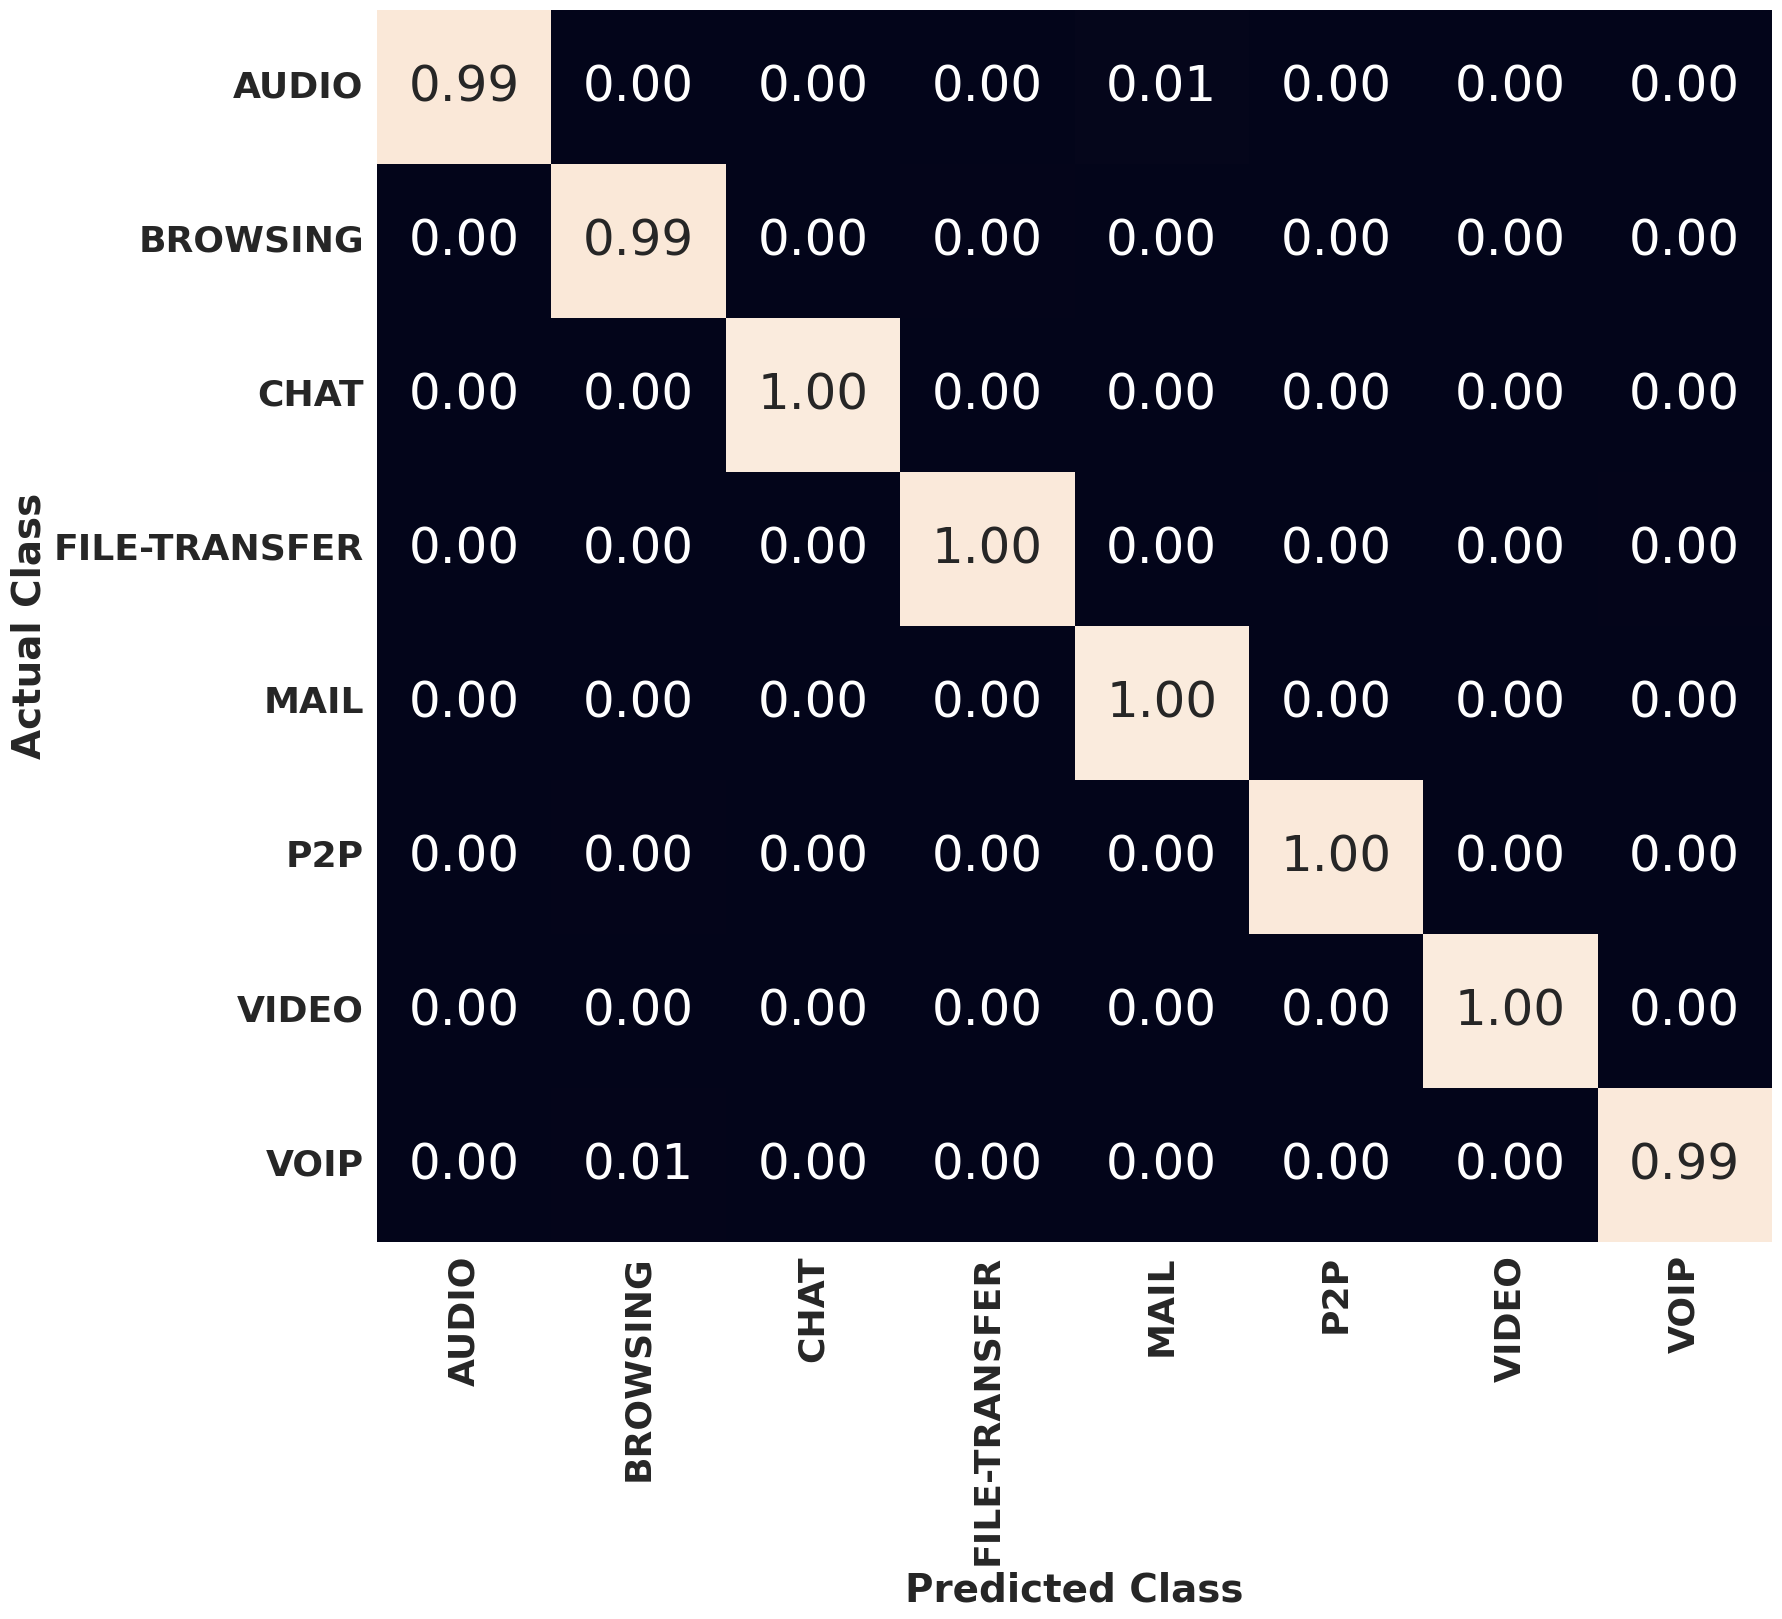

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred are your true labels and predicted labels, respectively
# Replace class_labels with the actual class labels in your problem
class_labels = ['AUDIO', 'BROWSING', 'CHAT', 'FILE-TRANSFER', 'MAIL', 'P2P',
       'VIDEO', 'VOIP']
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix to represent probabilities
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]

# Create a DataFrame from the normalized confusion matrix
cm_df = pd.DataFrame(cm_normalized, index=class_labels, columns=class_labels)
# Increase font size
sns.set(font_scale=3)
# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(18, 16))
heatmap = sns.heatmap(cm_df, annot=True, fmt='.2f', cbar=False)

# Customize x-axis and y-axis tick labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=26, fontweight='bold')
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=26, fontweight='bold')

# Customize labels and title
plt.xlabel('Predicted Class',fontsize=28, fontweight='bold')
plt.ylabel('Actual Class',fontsize=28, fontweight='bold')

# Save the plot as an EPS file
plt.savefig('/content/drive/MyDrive/xai/Tor Non Tor- Multi class/tor_confusion_matrix.eps', format='eps')

# Save the plot as a PNG file
plt.savefig('/content/drive/MyDrive/xai/Tor Non Tor- Multi class/tor_confusion_matrix.png', format='png')

# Show the plot
plt.show()


In [100]:
# Make predictions and measure prediction time per sample
import time
start_time = time.time()
y_pred = lgb.predict(X_test)
end_time = time.time()

# Calculate the prediction time per sample
total_samples = len(X_test)
prediction_time_per_sample = (end_time - start_time) / total_samples

print(f"Total prediction time: {end_time - start_time} seconds")
print(f"Prediction time per sample: {prediction_time_per_sample} seconds")

Total prediction time: 0.1468210220336914 seconds
Prediction time per sample: 7.30089617273453e-05 seconds


### Performance Comparison with different number of features

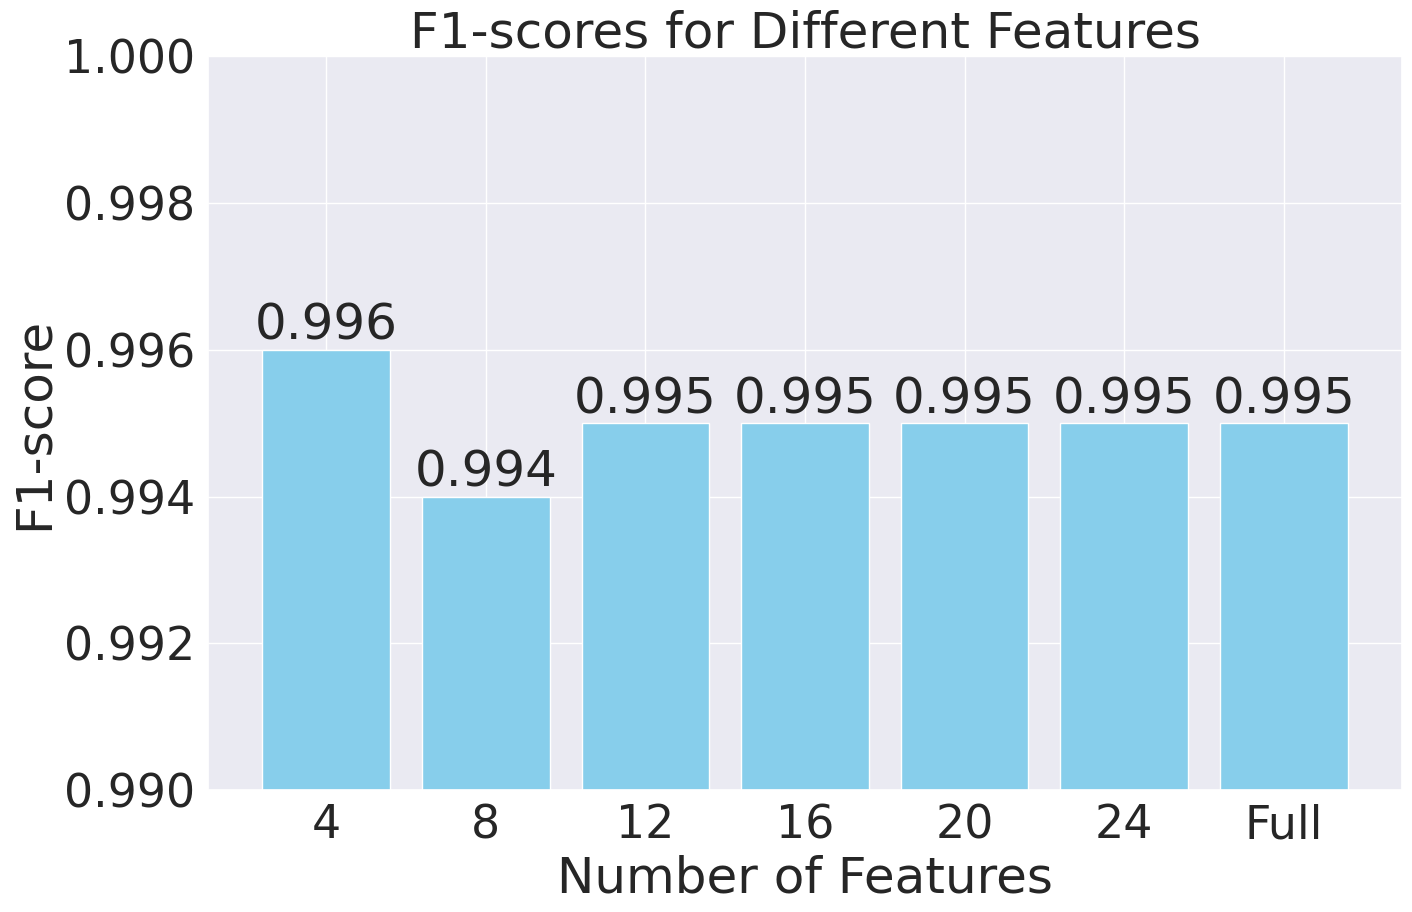

In [102]:
import matplotlib.pyplot as plt

# Data
features = ['4', '8', '12', '16', '20', '24', 'Full']
f1_scores = [0.996, 0.994, 0.995, 0.995, 0.995, 0.995, 0.995]

# Create the bar chart
fig, ax1 = plt.subplots(figsize=(15, 10))

# Bar chart for F1-scores
bars1 = ax1.bar(features, f1_scores, color='skyblue')
ax1.set_title('F1-scores for Different Features')
ax1.set_xlabel('Number of Features')
ax1.set_ylabel('F1-score')
ax1.set_ylim([0.990, 1.000])

# Add data labels for F1-scores
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom')

# Display the plot
plt.tight_layout()
plt.show()
